### Análise de Exportação de Vinhos - Brasil

O objetivo do Tech Challenge dessa Fase 1 é utilizar os dados de exportação disponíveis no repositório da embrapa para realizarmos uma análise estatística relacionada ao volume e valores de exportação de vinho do Brasil para o mundo, verificando os dados dos últimos 15 anos e também a influência de diversos fatores na otimização da exportação.  

In [1]:
#Libs que serão utilizadas:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
import re
import os 
import time
import locale
locale.setlocale(locale.LC_MONETARY, 'en_US.UTF-8')

'en_US.UTF-8'

Primeiramente iremos carregar os dados obtidos relacionados a exportação de Vinhos no Brasil.

In [2]:
#Carregando dados:
df_exportacao_vinhos = pd.read_csv("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/ExpVinho.csv", 
                                   sep = ";",
                                   encoding = 'UTF-8'
                                  ) 
#Verificando primeiros 5 valores:
df_exportacao_vinhos = df_exportacao_vinhos.drop(columns = "Id")

Podemos ver que os valores das Safras estão se repetindo, isso porque as safras com o sufixo .1 são as quantidades exportadas e as outras colunas são os valores das exportções.

In [3]:
#Criando nova dataframe de exportação de vinhos:
matrix = []
for pais in df_exportacao_vinhos["País"]:
    for safra in df_exportacao_vinhos.T.reset_index()["index"][1:]:
        matrix.append([pais, 
                       str(np.where(".1" in safra, "Valor (US$)", "Quantidade (Kg)")),
                       safra[0:4], 
                       int(df_exportacao_vinhos[df_exportacao_vinhos["País"] == pais][safra])])
df_vinhos_t = pd.DataFrame(matrix, columns = ["pais", "variavel", "safra", "valor"])
df_vinhos_t["safra"] = df_vinhos_t["safra"].astype(np.int64)

#Safras Ultimos 15 Anos:
safras_recentes = [x for x in range(2023-15, 2023, 1)]

#DataFrame Filtrada:
df_vinhos_t = df_vinhos_t.query("safra in @safras_recentes")

In [4]:
#Ajustando Valores:
valores_qtdes = df_vinhos_t.query("variavel == 'Quantidade (Kg)'") \
                           .groupby(["pais", "safra"]) \
                           .sum("valor").reset_index() \
                           .rename(columns = {"valor": "quantidade"})
valores_dinheiro = df_vinhos_t.query("variavel == 'Valor (US$)'") \
                           .groupby(["pais", "safra"]) \
                           .sum("valor").reset_index()

In [5]:
#Unindo tudo:
df_vinhos_ajustada = df_vinhos_t[["pais", "safra"]].drop_duplicates() \
                              .set_index(["pais", "safra"]) \
                              .join(valores_qtdes.set_index(["pais", "safra"]), on = ["pais", "safra"], how = "left") \
                              .join(valores_dinheiro.set_index(["pais", "safra"]), on = ["pais", "safra"], how = "left") \
                              .reset_index()
df_vinhos_ajustada.head()

,pais,safra,quantidade,valor
0,Afeganistão,2008,0,0
1,Afeganistão,2009,0,0
2,Afeganistão,2010,0,0
3,Afeganistão,2011,0,0
4,Afeganistão,2012,0,0


Podemos ver que agora as Safras estão filtradas somente para os últimos 15 Anos, facilitando a visualização dos dados por país. Além disso, todas as colunas de valores já estão em formato número, o que ajuda nas análises quantitativas.

#### Análise Descritiva

Vamos elencar alguns pontos primeiramente do que precisamos analisar e algumas hipóteses:

- Quais são os países com maior volume de exportação? E em Valor?
- Como são as Safras de Exportações mês a mês em média
- Algum país começou a ganhar destaque recentemente?

Primeiramente, vamos verificar qual o volume total exportado nos últimos 15 anos e o total de países nessa etapa.

In [7]:
#Total de Paises:
total_paises = df_vinhos_ajustada["pais"].drop_duplicates().count()
#Total Qtde Exportada:
total_qtde = df_vinhos_ajustada["quantidade"].sum()
#Total Valor Exportado:
total_valor = df_vinhos_ajustada["valor"].sum()
print(
    "Paises: {}, Total Qtde (Kg): {:,}, Total Valor (US$): {}".format(total_paises,
                                                                      total_qtde,
                                                                      locale.currency(total_valor, grouping=True))
)

Paises: 124, Total Qtde (Kg): 80,956,449, Total Valor (US$): $101,699,034.00


Claramente temos um volume bem alto de exportação, entretanto, são muitos países e seria dificil visualizar todos eles em gráficos adequados, dessa forma iremos verificar se existe uma assimetria na distribuição das exportações para podermos criar sub-categorias dos países.

In [8]:
#Valores Agregados por Paises:
df_agregada_pais = df_vinhos_ajustada.drop(columns = "safra").groupby("pais") \
                                     .sum(["quantidade", "valor"]).reset_index()

#Participação por Pais:
df_agregada_pais["% por Qtde"] = round(df_agregada_pais["quantidade"] / total_qtde, 3)
df_agregada_pais["% por Valor"] = round(df_agregada_pais["valor"] / total_valor, 3)
df_agregada_pais = df_agregada_pais.sort_values("% por Qtde", ascending = False)
df_agregada_pais["% Acum. Qtde"] = np.cumsum(df_agregada_pais["% por Qtde"])
df_agregada_pais["% Acum. Valor"] = np.cumsum(df_agregada_pais["% por Valor"])
df_agregada_pais["id"] = [i for i in range(1, len(df_agregada_pais)+1)]

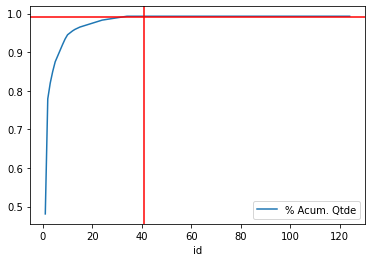

In [9]:
plot = df_agregada_pais.plot(x = "id", y = "% Acum. Qtde", kind = "line")
plot.axhline(0.99, color = "red")
plot.axvline(41, color = "red")

Dá para ver de forma clara que apesar de termos dados de 124 países, menos de 20 contribuem para informações sobre exportações de maneira relevante. Além disso, se pegarmos até os 41 paises, temos aproximadamente 99% da soma acumulada das quantidades e valores totais de exportação de vinhos. Com isso, podemos criar uma sub-categoria de pais, agrupando todos os paises restantes em um grupo chamado "Demais Paises". 

- Se o Id do País for <= 41, mantemos o país, caso contrário, será agrupado em Outros

In [10]:
#Nova Distribuição dos Paises:
paises_top_exportadores = list(df_agregada_pais.query("id <= 41")["pais"])
df_vinhos_ajustada["categoria_pais"] = [x if x in paises_top_exportadores 
                                        else "Demais Paises" 
                                        for x in df_vinhos_ajustada["pais"]]

Agora que temos os países reduzidos a 21 categorias menores, podemso visualizar de forma mais facilitada as informações. 

In [11]:
#Grafico do Total exportado:
somas_totais_paises = df_vinhos_ajustada[["categoria_pais", "quantidade", "valor"]]. \
                      groupby("categoria_pais").sum(["quantidade", "valor"]).reset_index()

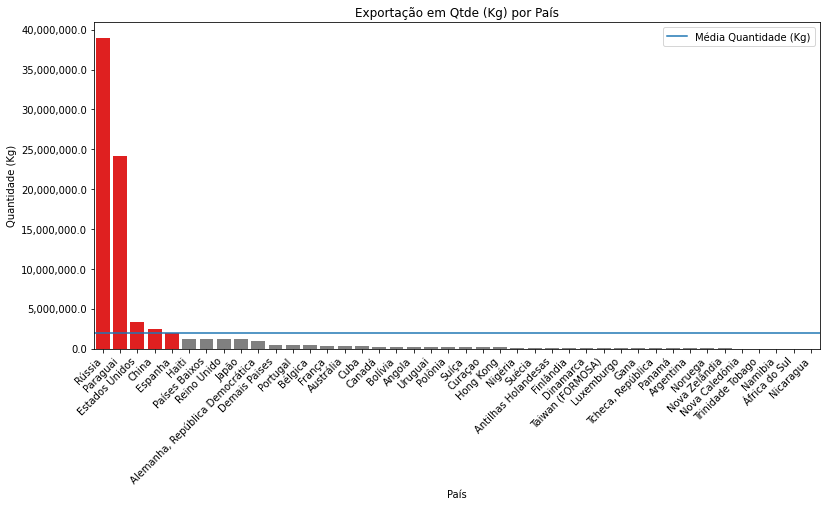

In [12]:
somas_totais_paises = somas_totais_paises.sort_values("quantidade", ascending=False)

#Grafico da Qtde de Exportação:
plt.figure(figsize = (13, 6))
media = np.mean(somas_totais_paises["quantidade"])
cor_media = ["red" if x > media else "grey" for x in somas_totais_paises["quantidade"]]
plot = sns.barplot(x = 'categoria_pais', y = 'quantidade', data = somas_totais_paises, palette = cor_media)
plt.xticks(rotation = 45, ha='right')
plot.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (Kg)")
plt.xlabel(xlabel = "País")
plot.axhline(np.mean(somas_totais_paises["quantidade"]), label = "Média Quantidade (Kg)")
plt.legend()
plt.title("Exportação em Qtde (Kg) por País")
plt.show()

- Como destacado anteriormente no gráfico das somas acumuladas, a distribuição das quantidades de exportações por paises nos últimos 15 anos é bem assimétrica, apenas 8 paises ficam acima ou iguais a média geral exportada dos 124 paises.

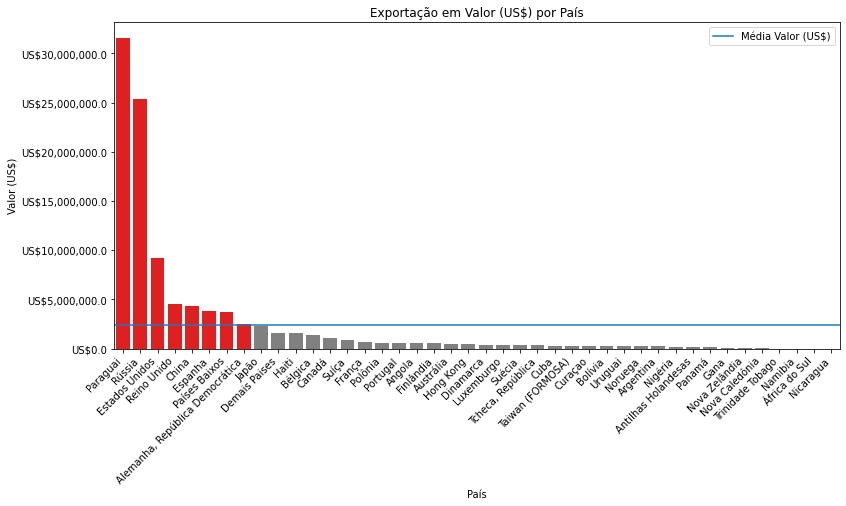

In [13]:
somas_totais_paises = somas_totais_paises.sort_values("valor", ascending=False)

#Grafico da Quantidade de Exportação:
plt.figure(figsize = (13, 6))
media = np.mean(somas_totais_paises["valor"])
cor_media = ["red" if x > media else "grey" for x in somas_totais_paises["valor"]]
plot = sns.barplot(x = 'categoria_pais', y = 'valor', data = somas_totais_paises, palette = cor_media)
plt.xticks(rotation = 45, ha='right')
plot.yaxis.set_major_formatter('US${x:,}')
plt.ylabel(ylabel = "Valor (US$)")
plt.xlabel(xlabel = "País")
plot.axhline(np.mean(somas_totais_paises["valor"]), label = "Média Valor (US$)")
plt.legend()
plt.title("Exportação em Valor (US$) por País")
plt.show()

- O mesmo vale para os valores totais exportados por país nos últimos 15 anos.

Qualquer gráfico que envolva legendas com os países não será fácil de visualizar, dessa forma, podemos sempre verificar os principais paises do nosso conjunto ou adicionar a informação dos continentes.

### Análises Temporais

In [14]:
#Pivotando Tabela para Plotarmos Quantidade e Valor Juntos:
df_safras_medias = df_vinhos_ajustada.groupby("safra")[["quantidade", "valor"]] \
    .agg({'quantidade': "sum", "valor": "sum"}) \
    .reset_index()
#df_safras_medias = df_safras_medias.melt(id_vars = ['safra'], value_vars = ['quantidade', 'valor'])

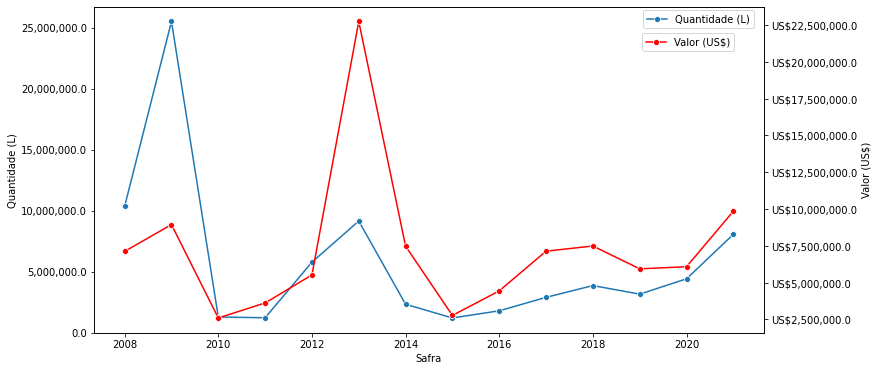

In [15]:
plt.figure(figsize = (12, 6))

#Axis 1 - Quantidade:
plot_qtde = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_safras_medias, marker = "o", label = "Quantidade (L)")
plot_qtde.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (L)")
plt.xlabel(xlabel = "Safra")
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper right', borderaxespad=1)
ax2 = plot_qtde.twinx()

#Axis 2 - Valor:
plot_valor = sns.lineplot(x = "safra", y = "valor", ax = ax2, 
             legend=True, data = df_safras_medias, color = "r", marker = "o", label = "Valor (US$)")
plot_valor.yaxis.set_major_formatter('US${x:,}')
plt.ylabel(ylabel = "Valor (US$)")
plt.xlabel(xlabel = "Safra")
plt.legend(bbox_to_anchor=(1, 1.01), loc='upper right', borderaxespad=3)
plt.show()

In [67]:
#Calculando Crescimento Anual da Quantidade:
cresc_safra = [None]
for i in range(1, len(df_safras_medias)):
    c = (df_safras_medias["quantidade"][i] / df_safras_medias["quantidade"][i-1]) - 1
    cresc_safra.append(c)

In [17]:
#Crescimento Anual do Paraguai:
df_safras_medias["% Crescimento Anual"] = cresc_safra

#Pallete Colors:
cols_cresc = ['red' if x < 0 else 'green' for x in cresc_safra[1:]]
cols_cresc.insert(0, "green")

C:\Users\lucaa\AppData\Local\Temp\ipykernel_8864\2831513690.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


[Text(0, -2.0, '-200%'),
 Text(0, -1.0, '-100%'),
 Text(0, 0.0, '0%'),
 Text(0, 1.0, '100%'),
 Text(0, 2.0, '200%'),
 Text(0, 3.0, '300%'),
 Text(0, 4.0, '400%')]

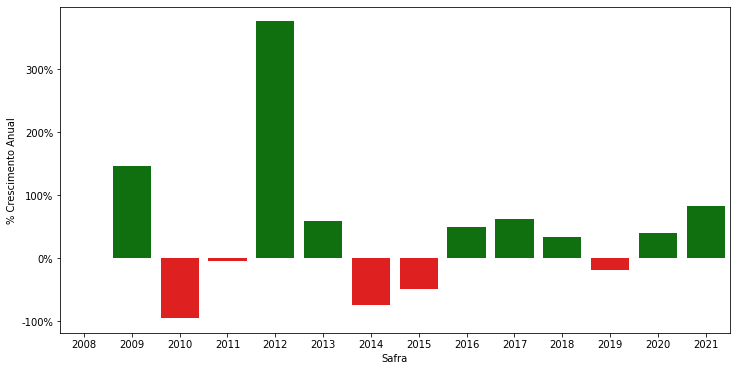

In [18]:
#Plotando o crescimento anual:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x = "safra", y = "% Crescimento Anual", data = df_safras_medias, palette = cols_cresc)
plt.ylabel(ylabel = "% Crescimento Anual")
plt.xlabel(xlabel = "Safra")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

Quando avaliamos a série completa, não observamos tendências evidentes nas exportações de vinhos, tanto em valor quanto em quantidade. Entretanto, podemos ver que os anos de 2008 e 2013 são discrepantes em relação as demais séries, caso esses anos sejam descartados, temos uma leve tendência positiva das médias anuais das quantidades e valores de exportações, chegando no maior valor em 2021, exportando aprox. 80 Mil Kg de vinho. 

Essa série leva em consideração a média anual de todos os paises, e, para verificarmos se essa tendência positiva observada de 2016 a 2021 é geral ou especifica para alguns paises, precisamos avaliar as séries individuais dos paises. Ainda mais pelo fato de termos uma distribuição nos valores muito assimétrica, isto é, concentração das exportações em poucos paises. 

In [19]:
#Continentes:
df_continentes = pd.read_excel("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/continentes.xlsx")

In [57]:
#Séries Individuais:
df_serie_individual = df_vinhos_ajustada[["pais", "safra", "quantidade", "valor"]] \
    .merge(df_continentes, on = "pais", how = "left") \
    .groupby(["continente", "safra"])[["quantidade", "valor"]] \
    .agg({"quantidade": "sum", "valor": "sum"}) \
    .reset_index()
df_serie_individual.head()

,continente,safra,quantidade,valor
0,América Central,2008,0,0
1,América Central,2009,24,24
2,América Central,2010,0,0
3,América Central,2011,0,0
4,América Central,2012,0,0


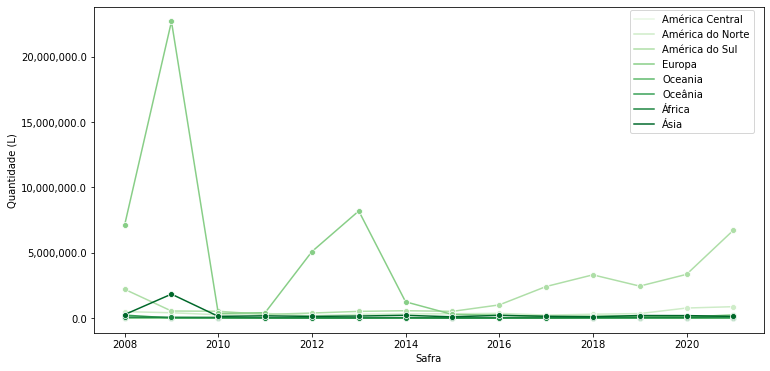

In [58]:
plt.figure(figsize = (12, 6))

#Axis 1 - Quantidade - Individual:
plot_qtde_ind = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_serie_individual, marker = "o", hue = "continente")
plot_qtde_ind.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (L)")
plt.xlabel(xlabel = "Safra")
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper right', borderaxespad=1)
#ax2 = plot_qtde.twinx()

Com essa visualização podemos verificar que aqueles pontos discrepantes na série geral são de responsabilidade da Europa, enquanto que a tendência positiva dos últimos 5 anos parece ser bastante influenciada pelas exportações para paises da América do Sul. 

Além disso, devido as escalas e o ponto discrepante da Europa em 2013, fica dificíl visualizar a tendência dos demais continentes. Logo, vamos verificar somente os últimos 5 anos da série.

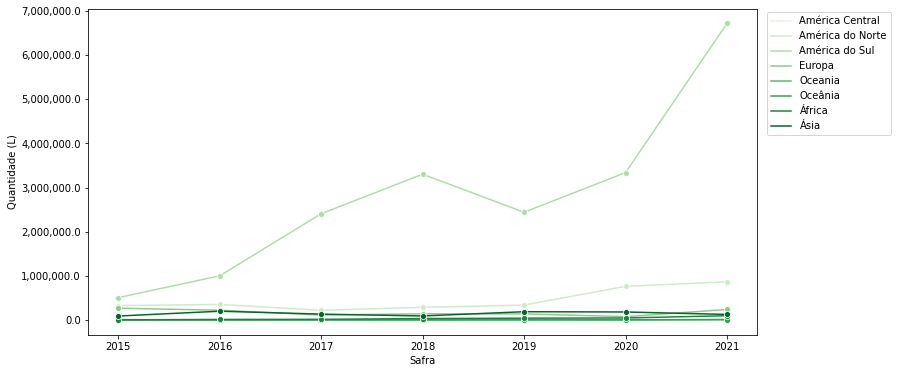

In [59]:
plt.figure(figsize = (12, 6))

df_serie_individual_5anos = df_serie_individual.query("safra >= 2015")

#Axis 1 - Quantidade - Individual:
plot_qtde_5anos = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_serie_individual_5anos, marker = "o", hue = "continente")
plot_qtde_5anos.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (L)")
plt.xlabel(xlabel = "Safra")
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='best', borderaxespad=1)

De fato, os paises da América do Sul são os responsáveis pelo crescimento das exportações, visto que os demais continentes apresentam valores constantes nos últimos anos. Essa informação pode ser relevante para nós para tentarmos entender o porque esses paises apresentam um total constante e entender também o porque a exportação para paises próximos está melhor que para os demais. 

### Explorando dados de Clima

Foram extraidos dados climáticos de 2013 em diante da região de bento gonçalves para verificarmos potenciais relações entre os totais de exportações e os dados climáticos anuais. Isso é importante, pois de acordo com  a produção de vinho requer muito trabalho, dedicação e conhecimento. Para produzir vinhos de alta qualidade, é preciso estar atento às condições meteorológicas, pois elas podem influenciar diretamente na qualidade e no sabor do vinho. É aí que entra a Estação Meteorológica, uma ferramenta importante para vinícolas que desejam ter um controle maior sobre o clima em sua região. 

In [23]:
df_clima = pd.read_excel("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/ClimaBentoGoncalves.xlsx")

In [24]:
df_clima = df_clima \
    .groupby("Ano") \
    .agg({"Tmin": "mean",
          "Tmax": "mean",
          "Tmed": "mean",
          "Precipitacao (mm)": "mean"}) \
    .reset_index()

In [25]:
#Dados de Produção de Vinhos:
df_prod = pd.read_csv("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/Producao.csv", 
                      sep = ";", header = None)
colunas_prod = [str(x) for x in range(1970, 2022, 1)]
colunas_prod.insert(0, "index")
colunas_prod.insert(1, "codigo_produto")
colunas_prod.insert(2, "descricao_produto")
df_prod.columns = colunas_prod

#Filtrando somente Vinhos de Mesa:
df_prod = df_prod.query("codigo_produto in ['VINHO DE MESA', 'VINHO FINO DE MESA (VINÍFERA)']") \
                 .drop(columns = ["index"])

In [26]:
#Ajustando a Tabela de Produção:
df_prod_safrada = pd.DataFrame()
for i in range(2):
    print(df_prod["codigo_produto"].values[i])
    if df_prod["codigo_produto"].values[i] == 'VINHO DE MESA':
        c = 0
    else: c = 4
    temp = df_prod.T.reset_index()[2:][["index", c]]
    temp.columns = ["safra", "quantidade"]
    temp["codigo_produto"] = df_prod["codigo_produto"].values[i]
    df_prod_safrada = pd.concat([
        df_prod_safrada,
        temp[["codigo_produto", "safra", "quantidade"]] 
    ])
df_prod_safrada["safra"] = df_prod_safrada["safra"].astype(int)
df_prod_safrada["quantidade"] = df_prod_safrada["quantidade"].astype(int)

#Filtrando Safras Recentes:
df_prod_safrada = df_prod_safrada.query('safra >= 2008') \
    .reset_index() \
    .drop(columns = ["index"])
df_prod_safrada.head()

VINHO DE MESA
VINHO FINO DE MESA (VINÍFERA)


,codigo_produto,safra,quantidade
0,VINHO DE MESA,2008,287506811
1,VINHO DE MESA,2009,205418206
2,VINHO DE MESA,2010,195267980
3,VINHO DE MESA,2011,257840749
4,VINHO DE MESA,2012,212777037


Text(0.5, 0, 'Safra')

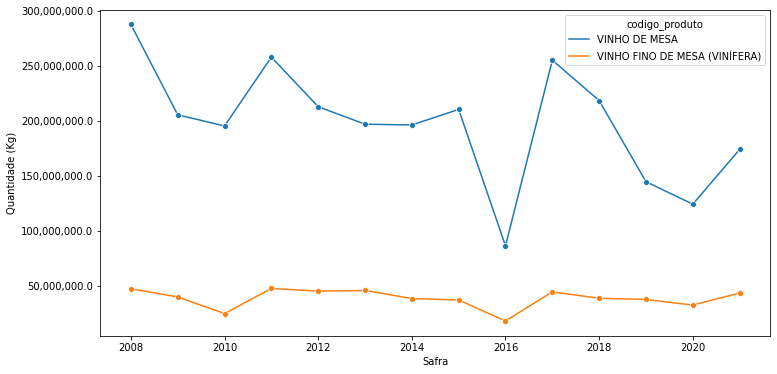

In [27]:
plt.figure(figsize = (12, 6))

#Séries das Produções:
plot_prod = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_prod_safrada, marker = "o", hue = "codigo_produto")
plot_prod.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (Kg)")
plt.xlabel(xlabel = "Safra")

Pela série acima podemos ver que as séries das produções por tipo de vinho apresentam comportamentos semelhantes, entretanto vinhos de mesas apresentaram quedas mais acentuadas em relação a algns anos, como 2009, 2010, 2019 e 2020. Uma das hipóteses que podemos verificar é a relação das produções pelos dados climáticos que coletamos.

In [28]:
#Dados de Produção COmbinados com dados CLimaticos:
df_clima_producao = df_prod_safrada \
    .groupby("safra") \
    .agg({"quantidade": "sum"}).reset_index() \
    .merge(df_clima, left_on = "safra", right_on = "Ano", how = "inner")

df_clima_producao

,safra,quantidade,Ano,Tmin,Tmax,Tmed,Precipitacao (mm)
0,2013,242686752,2013,12.533333,22.341667,17.016667,164.000000
1,2014,234637437,2014,14.166667,23.466667,18.183333,170.250000
2,2015,247457542,2015,14.291667,22.950000,18.016667,164.333333
3,2016,104389641,2016,13.116667,22.558333,17.200000,148.000000
4,2017,299553057,2017,14.141667,23.466667,18.250000,155.250000
5,2018,257082856,2018,13.633333,22.791667,17.591667,151.083333
6,2019,182245159,2019,14.025000,23.425000,18.158333,114.333333
7,2020,156717100,2020,13.266667,23.691667,17.866667,120.158333
8,2021,217374993,2021,12.111111,22.044444,16.477778,101.488889


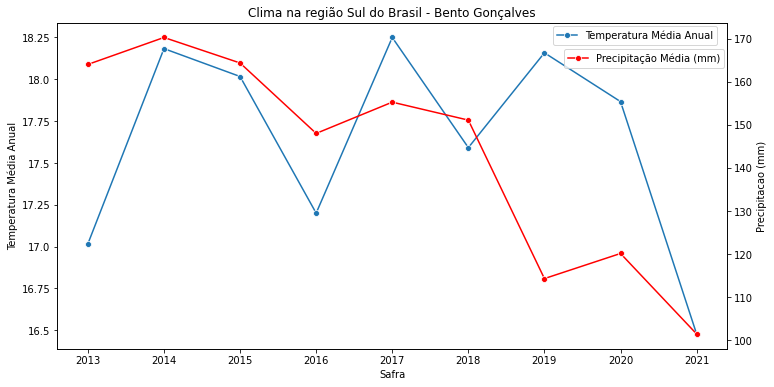

In [30]:
#Plotando temperatura Media e Precipitação Média:
plt.figure(figsize = (12, 6))

#Axis 1 - Produção:
plot_clima1 = sns.lineplot(x = "safra", y = "Tmed",
                  legend=True, data = df_clima_producao, marker = "o", label = "Temperatura Média Anual")
plot_clima1.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Temperatura Média Anual")
plt.xlabel(xlabel = "Safra")
plt.title("Clima na região Sul do Brasil - Bento Gonçalves")
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper right', borderaxespad=1)
ax2 = plot_clima1.twinx()

#Axis 2 - Clima:
plot_clima2 = sns.lineplot(x = "safra", y = "Precipitacao (mm)", ax = ax2, 
             legend=True, data = df_clima_producao, color = "r", marker = "o", label = "Precipitação Média (mm)")
plt.legend(bbox_to_anchor=(1.04, 1.01), loc='best', borderaxespad=3)
plt.show()

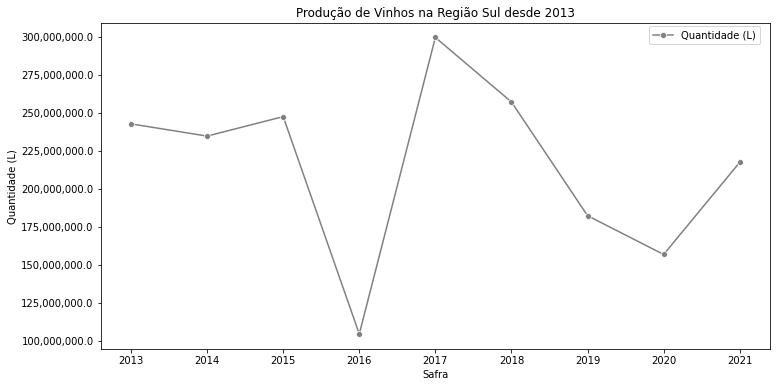

In [31]:
plt.figure(figsize = (12, 6))

#Axis 1 - Produção:
plotc_prod = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_clima_producao, marker = "o", label = "Quantidade (L)",
                         color = "grey")
plotc_prod.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (L)")
plt.xlabel(xlabel = "Safra")
plt.title("Produção de Vinhos na Região Sul desde 2013")
plt.legend(bbox_to_anchor=(1.0, 1.02), loc='upper right', borderaxespad=1)

Diversas visualizações foram testadas com a produção e os dados meteorologicos disponíveis. A variável que parece ter maior efeito na produção é a precipitação, que de fato é um fato determinante nas produções de vinhos, e pelo gráfico acima é possível verificar que a produção começou a declinar a partir de 2017 com a queda na precipitação média anual.

Apesar da produção estar aparentemente em declinio, as exportações para América do Sul continuaram sua tendência positiva de exportações, carregando os volumes totais de exportações, visto que os demais continentes e seus paises continuaram com exportações lineares. 

Agora para podermos verificar como manter as exportações crescendo, podemos realizar algumas visões especificas para América do Sul, verificando quais tipos de vinhos e a qualidade que da exportação, para prever possibilidades de aumentar a produção desses vinhos e consequentemente as exportações.

In [32]:
#Análise especifica para América do Sul:
df_america_do_sul = df_vinhos_ajustada[["pais", "safra", "quantidade", "valor"]] \
    .merge(df_continentes, on = "pais", how = "left") \
    .query("continente == 'América do Sul' and pais != 'Brasil'")
df_america_do_sul.head()

,pais,safra,quantidade,valor,continente,pais_en
98,Argentina,2008,0,0,América do Sul,Argentina
99,Argentina,2009,162,4523,América do Sul,Argentina
100,Argentina,2010,0,0,América do Sul,Argentina
101,Argentina,2011,13253,55460,América do Sul,Argentina
102,Argentina,2012,0,0,América do Sul,Argentina


Text(0.5, 0, 'País')

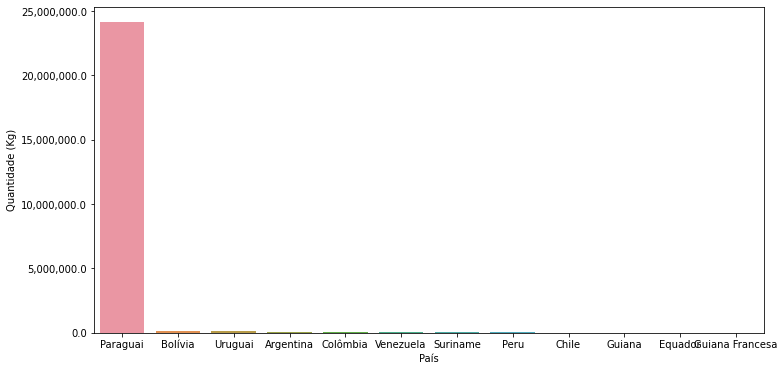

In [33]:
#Exportação por País da América do Sul:
df_america_total = df_america_do_sul \
    .groupby("pais") \
    .agg({"quantidade": "sum"}) \
    .reset_index() \
    .sort_values("quantidade", ascending = False)

plt.figure(figsize = (12, 6))
plot_as = sns.barplot(x = 'pais', y = 'quantidade', data = df_america_total)
plot_as.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (Kg)")
plt.xlabel(xlabel = "País")

A exportação para o Paraguai se dá de maneira tão intensa que é até dificil visualizar o ritmo dos demais paises do continente. Vamos verificar as séries desses paises individualmente.

In [34]:
df_america_safra = df_america_do_sul \
    .groupby(["pais", "safra"]) \
    .agg({"quantidade": "sum"}) \
    .reset_index()

Text(0.5, 0, 'Safra')

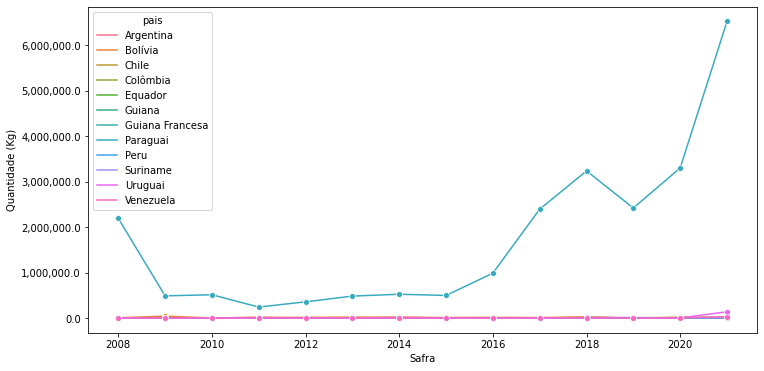

In [35]:
plt.figure(figsize = (12, 6))
sns.set_palette(sns.color_palette("Greens", 8))
plot_as_pais = sns.lineplot(x = "safra", y = "quantidade",
                  legend=True, data = df_america_safra, marker = "o", hue = 'pais')
plot_as_pais.yaxis.set_major_formatter('{x:,}')
plt.ylabel(ylabel = "Quantidade (Kg)")
plt.xlabel(xlabel = "Safra")

Praticamente todas as exportações que estamos realizando nos últimos 15 anos, como um todo, foram feitas para o Paraguai, o montante exportado para ele é bem agressivo, e parece ser definitivamente a maior porção. Para verificar isso também vamos calcular a participação do paraguai em relação ao total exportado por ano e plotar para verificarmos a tendência.

In [36]:
#Participação por Safra e Pais:
df_agregada_pais_safra = df_vinhos_ajustada \
    .groupby(["pais", "safra"]) \
    .sum(["quantidade", "valor"]).reset_index()
df_agregada_pais_safra.head()

,pais,safra,quantidade,valor
0,Afeganistão,2008,0,0
1,Afeganistão,2009,0,0
2,Afeganistão,2010,0,0
3,Afeganistão,2011,0,0
4,Afeganistão,2012,0,0


In [37]:
df_acumulada_por_safra_pais = pd.DataFrame()
#Loopando por Safra:
for s in np.unique(df_agregada_pais_safra["safra"]):
    #Df Safrada:
    temp = df_agregada_pais_safra.copy().query("safra == @s")
    
    #Totais:
    total_temp = np.sum(temp["quantidade"])
    
    #Participação por Pais e Safra:
    temp["% por Qtde"] = round(temp["quantidade"] / total_temp, 3)
    temp = temp.sort_values("% por Qtde", ascending = False)
    temp["% Acum. Qtde"] = np.cumsum(temp["% por Qtde"])
    
    df_acumulada_por_safra_pais = pd.concat([
        df_acumulada_por_safra_pais,
        temp
    ])

C:\Users\lucaa\AppData\Local\Temp\ipykernel_8864\1754153662.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



[Text(0, 0.0, '0%'),
 Text(0, 0.2, '20%'),
 Text(0, 0.4, '40%'),
 Text(0, 0.6000000000000001, '60%'),
 Text(0, 0.8, '80%'),
 Text(0, 1.0, '100%')]

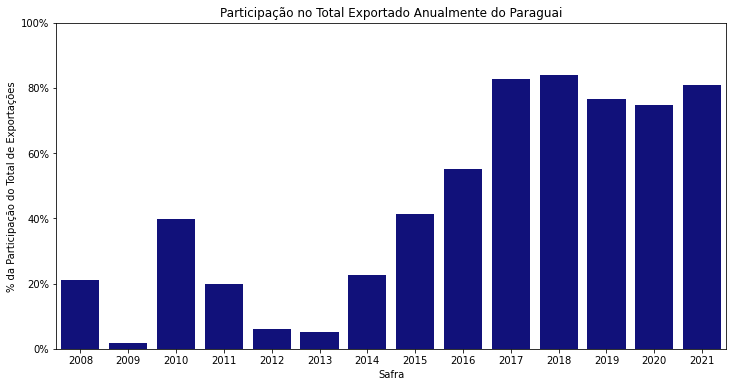

In [64]:
plt.figure(figsize = (12, 6))
plot_as_pais = sns.barplot(x = "safra", y = "% por Qtde",
                           data = df_acumulada_por_safra_pais.query("pais == 'Paraguai'"), color='darkblue')
plt.ylabel(ylabel = "% da Participação do Total de Exportações")
plt.xlabel(xlabel = "Safra")
plt.title("Participação no Total Exportado Anualmente do Paraguai")
plt.ylim((0, 1))
# manipulate
vals = plot_as_pais.get_yticks()
plot_as_pais.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

Claramente o Paraguai tornou-se o nosso principal importador de vinhos, de 2008 a 2014, o % de participação do país no total exportado em quantidade era abaixo de 20%, e ganhou uma tendência positiva agressiva de crescimento, chegando a mais de 70% do total exportado a em 2021, representando um crescimento superior a 200%, influenciando diretamente na capacidade do país.

In [39]:
#Crescimento Anual do Paraguai:
df_paraguai = df_acumulada_por_safra_pais.query("pais == 'Paraguai'").reset_index().drop(columns = {"index"})
variacoes = [None]
for i in range(1, len(df_paraguai)):
    variacao = (df_paraguai["% por Qtde"][i] / df_paraguai["% por Qtde"][i-1]) - 1
    variacoes.append(variacao)
df_paraguai["Variação"] = variacoes

#Pallete Colors:
cols_paraguai = ['red' if x < 0 else 'green' for x in variacoes[1:]]
cols_paraguai.insert(0, "green")

C:\Users\lucaa\AppData\Local\Temp\ipykernel_8864\2220917068.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


[Text(0, -5.0, '-500%'),
 Text(0, 0.0, '0%'),
 Text(0, 5.0, '500%'),
 Text(0, 10.0, '1,000%'),
 Text(0, 15.0, '1,500%'),
 Text(0, 20.0, '2,000%'),
 Text(0, 25.0, '2,500%')]

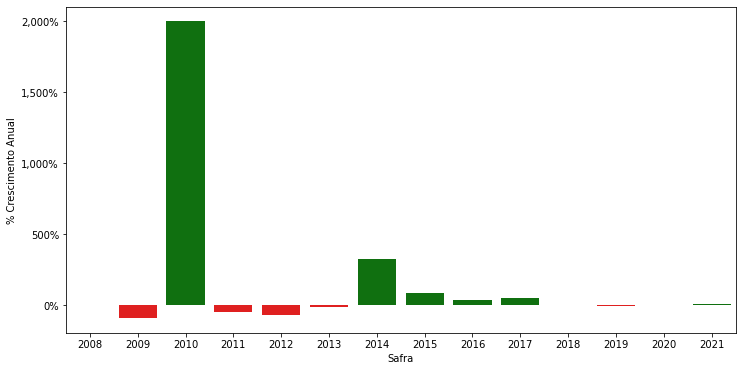

In [40]:
#Plotando o crescimento anual:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x = "safra", y = "Variação", data = df_paraguai, palette = cols_paraguai)
plt.ylabel(ylabel = "% Crescimento Anual")
plt.xlabel(xlabel = "Safra")
# manipulate
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

O crescimento a partir de 2013 é bem significativo, só tendo crescimentos positivos de ano para ano.

Quando analisamos os dados economicos do Paraguai, o crescimento nas exportações realizadas para ele são embasadas pelo desenvolvimento de sua economia, desdde 2008 o PIB do país cresceu em um rumo acelerado, assim como suas improtações e exportações. Até 2008, as exportações ficaram inferiores a 10 Bilhões de dólares, e a partir de 2008 também começaram a crescer, chegando a 13,4 Bilhões de dólares em 2021.

Plotando a participação das exportações do paraguai em comparação aos demais paises

In [41]:
df_acumulada_por_safra_pais["cat_pais"] = np.where(df_acumulada_por_safra_pais["pais"] == "Paraguai", "Paraguai", "Outros Paises")

In [42]:
df_acum_cat = df_acumulada_por_safra_pais \
    .groupby(["cat_pais", "safra"]) \
    .agg({"% por Qtde": "sum"}) \
    .reset_index()
df_acum_cat.head()

,cat_pais,safra,% por Qtde
0,Outros Paises,2008,0.786
1,Outros Paises,2009,0.981
2,Outros Paises,2010,0.601
3,Outros Paises,2011,0.803
4,Outros Paises,2012,0.934


In [44]:
#Paises Traduzidos:
df_paises = pd.read_excel("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/continentes.xlsx") \
    .transform(lambda x: x.strip() if type(x) == str else x)

#Adicionando Coordenadas aos Valores:
df_map = df_vinhos_ajustada \
    .groupby("pais") \
    .agg({"quantidade":"sum"}) \
    .reset_index() \
    .merge(df_paises, on = "pais", how = "inner")
df_map.head()

,pais,quantidade,continente,pais_en
0,Afeganistão,11,Ásia,Afghanistan
1,"Alemanha, República Democrática",901421,Europa,Germany
2,Angola,164800,África,Angola
3,Anguilla,0,Europa,Anguilla
4,Antilhas Holandesas,97002,América do Norte,Netherlands Antilles


In [45]:
from urllib.request import urlopen
import json
import plotly.express as px

In [46]:
#Paises Infos Loc:
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)

In [47]:
#Infos dos Paises de Exp Qtde com Code:
df_plotly = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/2014_world_gdp_with_codes.csv') \
    .transform(lambda x: x.strip() if type(x) == str else x) \
    .merge(df_map, left_on = "COUNTRY", right_on = "pais_en", how = "inner") \
    [["pais_en", "CODE", "pais", "quantidade"]]

In [48]:
df_plotly.query("pais == 'Paraguai'")

,pais_en,CODE,pais,quantidade
80,Paraguay,PRY,Paraguai,24138100


In [69]:
import plotly.graph_objects as go

In [70]:
fig = go.Figure(data=go.Choropleth(
    locations = df_plotly['CODE'],
    z = df_plotly['quantidade'],
    text = df_plotly['pais_en'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=False,
    marker_line_color='black',
    marker_line_width=0.5,
    colorbar_title = 'Quantidade (L)',
))

fig.show()

Verificando Indicadores socioeconomicos do paraguai e outros paises

In [71]:
df_econ = pd.read_excel("C:/Users/lucaa/Desktop/Pós Tech Data Analytics/Fase 1/Tech Challenge/Data/content/GDP.xlsx", sheet_name = "Planilha1") \
    .transform(lambda x: x.strip() if type(x) == str else x) 

In [52]:
#Safras Import:
safras_econ = [x for x in range(2006, 2023)]
#Transpondo Valores:
df_econ_t = pd.DataFrame()
for p in df_econ["Country"]:
    temp = df_econ.copy() \
        .query("Country == @p").T \
        .reset_index() \
        .query("index != 'Country'")
    temp.columns = ["safras", "total_importado"]
    temp["safras"] = temp["safras"].astype(int)
    temp["pais"] = p
    df_econ_t =pd.concat([df_econ_t, temp[["pais", "safras", "total_importado"]]])

In [53]:
df_econ_t.copy().query("pais in ['Paraguay', 'United States', 'Russian Federation']").to_clipboard(index = False)

Vamos tentar extrapolar linearmente as exportações do futuro.

In [65]:
#Totais por Safra:
df_futura = df_vinhos_ajustada \
    .groupby("safra") \
    .agg({"quantidade": "sum", "valor": "sum"}) \
    .reset_index()

In [66]:
df_futura.to_clipboard(index = False)